# Evaluation:
---


In [62]:
#imports
import sys
import os
import time
import logging
import json
import numpy as np
import torch
import matplotlib.pyplot as plt

# Add project root to sys.path
script_dir = os.path.dirname(os.path.abspath("__main__"))
project_root = os.path.dirname(script_dir)
sys.path.append(project_root)

#data loader imports
from Dataset.data_loaders import create_dataloaders

#import dact-bert
from Models.DACT_BERT import DACT_BERT
from Models.VanillaBert import VanillaBert
from Models.DactBert.dact_bert import TrainingEngine, DactBert
from Models.BackBone.back_bone import BackBone

# Pre-trained DACT-BERT
---
DACT-BERT can be trained in the standard manner or can be built from a configuration file. The configuration file is generated in a multi-step sequence.

### Prebuilt  Config File:  
I have pre-built the configuration file being used here for usability, as the process to build such a configuration file is complex and resource-intensive.  
Below I will detail the process should you wish to generate your own.

### Building a Config File:  
I have built both a `TuningEngine` and a `TrainingEngine` class, available within `Models/DactBert/dact_bert.py` which work together to tune the architectures of the submodels within the DACT-UNIT, as well as tune the external parameters and the value of lambda-reg (the scaler overseeing the trade off between accuracy and layer exit).  
If you wish to generate your own config file, all you need to do is run the following:  
`tuning_engine = TuningEngine(output_dimension=3, time_out=60)`  
`metrics_save_path, model_weights_path = tuning_engine.run_pipeline(run_tag="name")`  

This returns two paths, one to the model's configuration file, and the other to the model's final training and validation metrics. An external configuration file is silently created in the pipeline and stored within `DactBert/ExternalConfigs`.  
I am currently working on making this pipeline more user freindly, but it's design was intended to be asynchronously capable.  

### Evaluation:  
In this notebook, I am using a configuration file that has already been generated to evaluate DactBert's performance on the test set.

In [2]:
#load in the configuration path
model_config_file_path = os.path.join('..', 'Models', 'DactBert', 'Configuration', 'dact_bert_configuration_TUNED.json')
model_config_file_path = os.path.abspath(model_config_file_path)

#load the model from configuration
dact_bert = DactBert.load_from_config(model_config_file_path)

2025-03-15 16:51:02,998 - INFO - Loading from Pre-built Configuration...

2025-03-15 16:51:03,115 - INFO - Loading provided BackBone weights...

2025-03-15 16:51:06,398 - INFO - Config is Dict Type.

2025-03-15 16:51:06,400 - INFO - Config is Dict Type.

2025-03-15 16:51:06,401 - INFO - Architecture dict provided.

2025-03-15 16:51:06,402 - INFO - Building classifier submodel from dict...

2025-03-15 16:51:06,417 - INFO - Returning custom architecture.

2025-03-15 16:51:06,418 - INFO - Architecture dict provided.

2025-03-15 16:51:06,419 - INFO - Building confidence submodel from dict...

2025-03-15 16:51:06,421 - INFO - Returning custom architecture.

2025-03-15 16:51:06,422 - INFO - Configuring Pre-Trained Weights...

2025-03-15 16:51:06,784 - INFO - Model Ready.



### Training and Validation Accuracy:
Since the metrics are pre-generated when the configuration file is generated, lets load in the metrics and plot them.

In [4]:
#load in model metrics path:
metrics_data_path = os.path.join('..', 'Models', 'DactBert', 'Metrics', 'dact_bert_metrics_TUNED.json')
metrics_data_path = os.path.abspath(metrics_data_path)

#load model metrics:
with open(metrics_data_path, "r") as metrics_file:
    metrics_data = json.load(metrics_file)

#unpack data
train_losses = metrics_data["train_losses"]
validation_losses = metrics_data["validation_losses"]
train_accuracies = metrics_data["train_accuracies"]
validation_accuracies = metrics_data["validation_accuracies"]

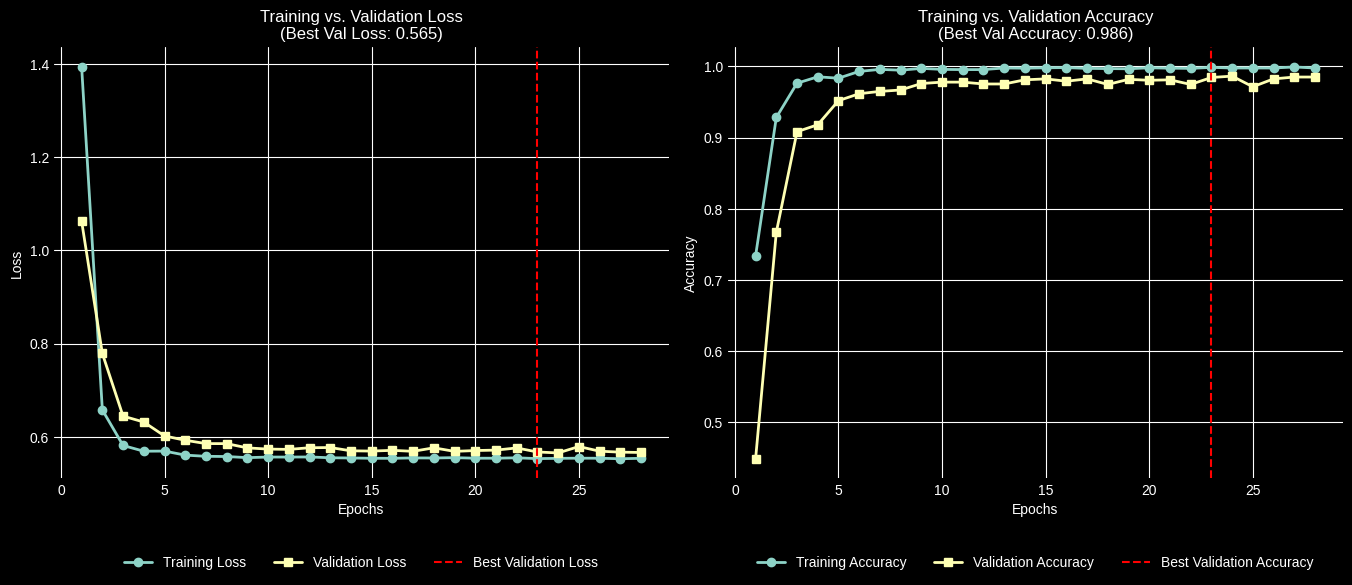

In [35]:
#plotting configuration metrics
epochs = range(1, len(train_losses) + 1)

#get the maximal accuracy and minimal loss (validation)
max_val_idx = np.array(validation_accuracies).argmax()
max_val_acc = validation_accuracies[max_val_idx]

min_val_idx = np.array(validation_losses).argmin()
min_val_loss = validation_losses[min_val_idx]

#set the style and the figure
plt.style.use('dark_background')
plt.figure(figsize=(14, 6))

# plotting Losses
ax1 = plt.subplot(1, 2, 1)
ax1.plot(epochs, train_losses, label="Training Loss", marker='o', linewidth=2)
ax1.plot(epochs, validation_losses, label="Validation Loss", marker='s', linewidth=2)
ax1.axvline(x=min_val_idx, color="red", label="Best Validation Loss", linestyle="--")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title(f"Training vs. Validation Loss\n(Best Val Loss: {min_val_loss:.3f})")
ax1.grid(True)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# plotting Accuracies
ax2 = plt.subplot(1, 2, 2)
ax2.plot(epochs, train_accuracies, label="Training Accuracy", marker='o', linewidth=2)
ax2.plot(epochs, validation_accuracies, label="Validation Accuracy", marker='s', linewidth=2)
ax2.axvline(x=max_val_idx, color="red", label="Best Validation Accuracy", linestyle="--")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title(f"Training vs. Validation Accuracy\n(Best Val Accuracy: {max_val_acc:.3f})")
ax2.grid(True)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

#show
plt.tight_layout()
plt.show()

## Testing Performance:
The external parameters describe how the model was trained, so lets load in the testing data from the same split that the model was trained on and evaluate it's performance:

In [36]:
#load in pre-tuned external configs
external_config_path = os.path.join('..', 'Models', 'DactBert', 'ExternalConfigs', 'external_config_TUNED.json')
external_config_path = os.path.abspath(external_config_path)

#load in the external configuration
with open(external_config_path, "r") as external_config_file:
    external_config = json.load(external_config_file)
    
#extract needed params for dataloader:
split_prop = external_config["split_prop"]
batch_size = external_config["batch_size"]

#Load the test data loader in
_, _, test_dataloader = create_dataloaders(split_prop=split_prop, batch_size=batch_size)

2025-03-15 17:09:40,640 - INFO - Loading tokenizer...

2025-03-15 17:09:40,797 - INFO - Successfully loaded tokenizer.

2025-03-15 17:09:40,798 - INFO - Loading Datasets...

2025-03-15 17:09:40,799 - INFO - Checking Split Choice: Train...
2025-03-15 17:09:40,800 - INFO - Selected valid split.

2025-03-15 17:09:40,801 - INFO - Attempting to load data

2025-03-15 17:09:40,805 - INFO - Successfully Loaded Dataset.

2025-03-15 17:09:40,805 - INFO - Checking Split Choice: Valid...
2025-03-15 17:09:40,806 - INFO - Selected valid split.

2025-03-15 17:09:40,807 - INFO - Attempting to load data

2025-03-15 17:09:40,810 - INFO - Successfully Loaded Dataset.

2025-03-15 17:09:40,810 - INFO - Checking Split Choice: Test...
2025-03-15 17:09:40,811 - INFO - Selected valid split.

2025-03-15 17:09:40,812 - INFO - Attempting to load data

2025-03-15 17:09:40,815 - INFO - Successfully Loaded Dataset.

2025-03-15 17:09:40,816 - INFO - Successfully loaded datasets.

2025-03-15 17:09:40,816 - INFO - Crea

In [72]:
#define inference
def model_testing(model, test_dataloader):
    ''' Simple helper function to calculate the testing metrics'''
    #define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #storage for losses and accuracy
    all_labels = []
    all_preds = []
    exited_layers = []
    
    
    #set model to eval
    model.to(device)
    model.eval()
    
    #turn off gradient computation
    with torch.no_grad():
        for batch in test_dataloader:
            #send to device
            batch={k:v.to(device) for k, v in batch.items()}
    
            #unpack
            labels = batch["labels"].long()
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]

            outputs, exit_layers,_ = model(input_ids, attention_mask)
            exited_layers.append(exit_layers)

            #predictions
            predictions = outputs.argmax(dim=1)
            
            #store
            all_preds.append(predictions.detach().cpu())
            all_labels.append(labels.detach().cpu())
            
    #calculate the metrics
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    testing_accuracy = (all_preds==all_labels).float().mean().item()
    aggregated_exit_layers = np.sum(np.array(exited_layers), axis=0)
    return testing_accuracy, aggregated_exit_layers, batch_times

#load in results
dact_accuracy, dact_exit_layers, dact_batch_times = model_testing(dact_bert, test_dataloader)

In [73]:
print("=" * 40)
print("DACT-BERT Model Evaluation Report")
print("=" * 40)

# print accuracy
print(f"Final Testing Accuracy: {dact_accuracy * 100:.2f}%")

# print exit layer statistics
print("\nExit Layer Distribution:")
for i, count in enumerate(dact_exit_layers):
    print(f"  Layer {i + 1}: {count} exits")

# print inference time stats
avg_inference_time = sum(dact_batch_times) / len(dact_batch_times)
max_inference_time = max(dact_batch_times)
min_inference_time = min(dact_batch_times)

print("\nInference Time per Sample (in seconds):")
print(f"  Average: {avg_inference_time:.6f}")
print(f"  Max: {max_inference_time:.6f}")
print(f"  Min: {min_inference_time:.6f}")

print("=" * 40)


DACT-BERT Model Evaluation Report
Final Testing Accuracy: 98.48%

Exit Layer Distribution:
  Layer 1: 22.0 exits
  Layer 2: 0.0 exits
  Layer 3: 0.0 exits
  Layer 4: 0.0 exits
  Layer 5: 0.0 exits
  Layer 6: 0.0 exits

Inference Time per Sample (in seconds):
  Average: 0.000031
  Max: 0.000064
  Min: 0.000028
